# Prédiction de volatilités

## Présentation du jeu de données

### Introduction

Dans le cadre de la gestion de capital, le risque associé a un port-folio d'actif est une quantité primordiale dans l'équilibrage de ce dernier. Dans le cadre de stratégies plus aggressives, la volatilité de fin séance est une variable d'une grande importance pour des raisons de gestion du risque et d'optimisation des résultats. Capital Fund Management (CFM) a ainsi en 2018 proposé comme défi d'apprentissage automatique l'estimation de volatilité de cloture sur les marchés actions US. Il existe de nombreuses manières de calculer la volatilité d'un actif et CFM a imposé sa propre formule non divulguée, la volatilité dépendant de la modélisation que l'on considère la mieux adaptée pour un actif et une stratégie donnés.

Le jeu de données est composé, pour un ensemble d'actions (318 précisement) issues du marche américain de la volatilité et du signe du rendement (au sens de CFM) toutes les 5 minutes de 9h30 à 14h pour un jour donnée. A partir de ces données historiques de volatilités devait être prédit la volatilité moyenne des deux dernières heures avant clôture de la journée. Ainsi on dispose de séries temporelles pour un ensemble de date et de produits fixés (ces classes sont approximativement équi-distribuées), chacune de ces séries étant associée à une grandeur réelle positive à prédire.

Nous disposons, de plus, d'un second jeu de données test, où les cibles sont absentes, et dont la précision des prédictions est obtenue en soumettant nos résultats à CFM.

De manière surprenante, le choix de la métrique est la MAPE, qui est connue pour son instabilité et qui est malheureusement peu supportée par les bibliothèques standards de Machine Learning.

De l'aveu de l'organisateur lui-même, faire sensiblement mieux qu'une régression linéaire aurait très difficile. Ce constat est partagé à la suite de notre étude. Étant un challenge déjà terminé, le meilleures score est public et s´élève à 20.7%, obtenu semble-t-il par stacking de réseaux de neuronnes.

Ce challenge nous a permis d'améliorer notre méthodologie, mesurer la difficulté d'optimiser un modèle qui marche déjà bien, nous a réservé des surprises en termes de compromis biais-variance (rajouter des colonnes peut sensiblement détériorer un modèle) et nous a permis de s'essayer à des bibliothèques de Machine Learning montantes.

En raison de la taille de nos données, et comme nous le verrons plus loin du nombre de modèles à générer et optimiser, nous avons choisi de réaliser notre projet en python. Nous utilisons ainsi la bibliothèque H2o, qui couplée au cluster de calcul de l'université Paris-Sud, permet d'optimiser nos calculs et de les paralléliser

In [1]:
import io

import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from ipypublish import nb_setup

pd = nb_setup.setup_pandas(escape_latex=False)

from sklearn.linear_model import LinearRegression, Lars
from mlinsights.mlmodel import QuantileLinearRegression
from sklearn.preprocessing import OneHotEncoder

sns.set()

In [2]:
from submit import submit, submit_dataframe

In [3]:
# Loading the raw training data

train_raw = dd.read_csv("preprocess/training_without_imputation/*.part").compute(scheduler="processes")

test_raw = pd.read_csv("data/testing_input.csv", sep=";")

In [4]:
vol_cols = train_raw.columns[train_raw.columns.str.contains("volatility")]

### Description succinte des données

Les données contiennent trois groupes de variables prédictrices:

* *volatilités*: 54 colonnes qui represente les volatilités prises toutes les 5 minutes de 9h30 inclus à 14h exclus.
* *signe du rendement*: 54 colonnes avec le même échantillonage que précedemment.
* *contexte*: 3 colonnes identifiant du produit, identifiant de la date, identifiant unique de la série temporelle.



Les identifiants associés aux dates ont été mis au hasard sans considérer leur caractère séquentiel. Les identifiants des produits sont anonymisés.

Le nombre de date de quotation s'élève à 2117 jours, sachant qu'il y a 253 jours de quotation par an, on obtient un peu plus de 8 années de quotation.

Le fait que l'on ne puisse pas considérer les dates de manière séquentielle est handicapant. On ne peut ansi rajouter en terme de colonnes les volatilités du jour qui précéde ou une moyenne des volatilités sur la semaine. Il s'agit cependant d'un choix logique, étant donné qu'il serait possible d'utiliser la volatilité d'ouverture de séance pour aider à la prédiction de la volatilité de fin de séance de la veille, ce qui réduirait considérablement l'intérêt réel des prédictions.


### Visualisation

#### Exemple d'une série temporelle obtenue



Nous en affichons ici trois et nous remarquons des comportements très différents en termes de pics de volatilités. Ainsi la première série a un pic en début de séance, tandis cela n'apparait qu'en fin d'après-midi pour la seconde, tandis que les pics de la troisième ont lieu en début et milieu de matinée.

De manière générale, les observations empiriques des marchés financiers décrites dans plusieurs articles permettent de constater une forme de "U" au cours de la journée, avec une volatilité forte en début de session, plus faible en milieu de journée, avec une remonté en fin de session, sans toutefois généralement atteindre la volatilité de début de session.


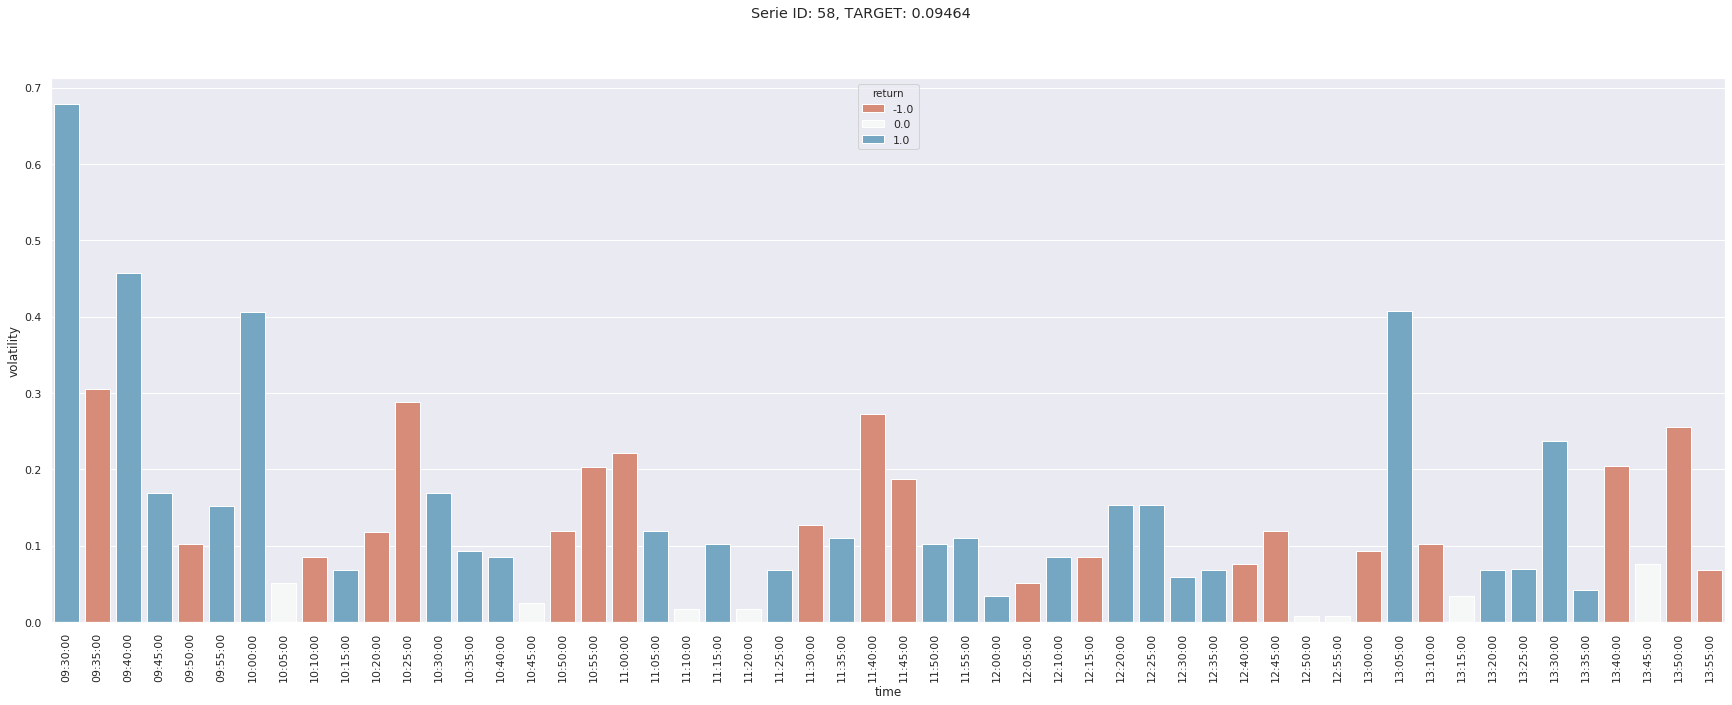

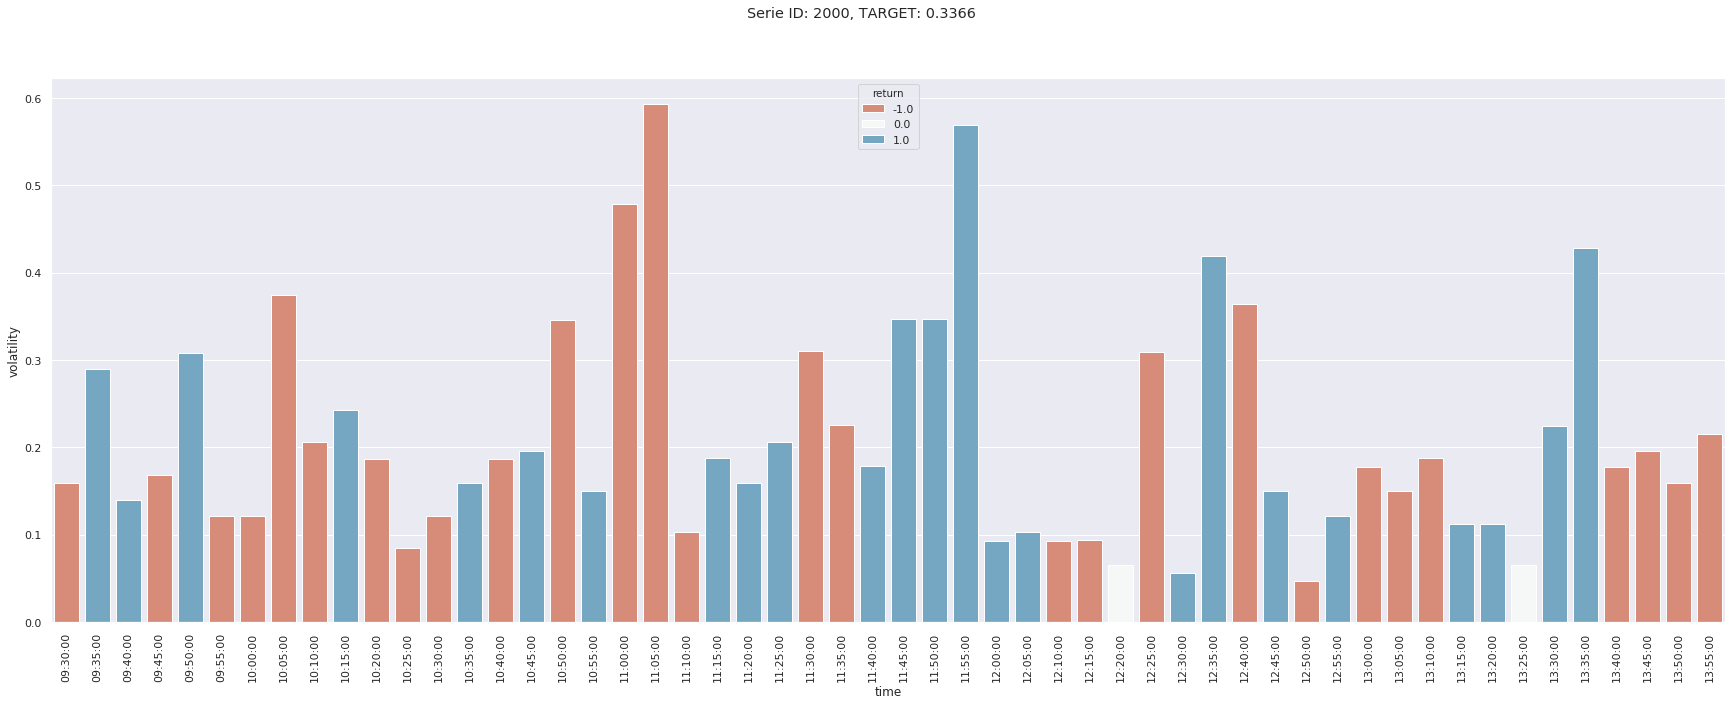

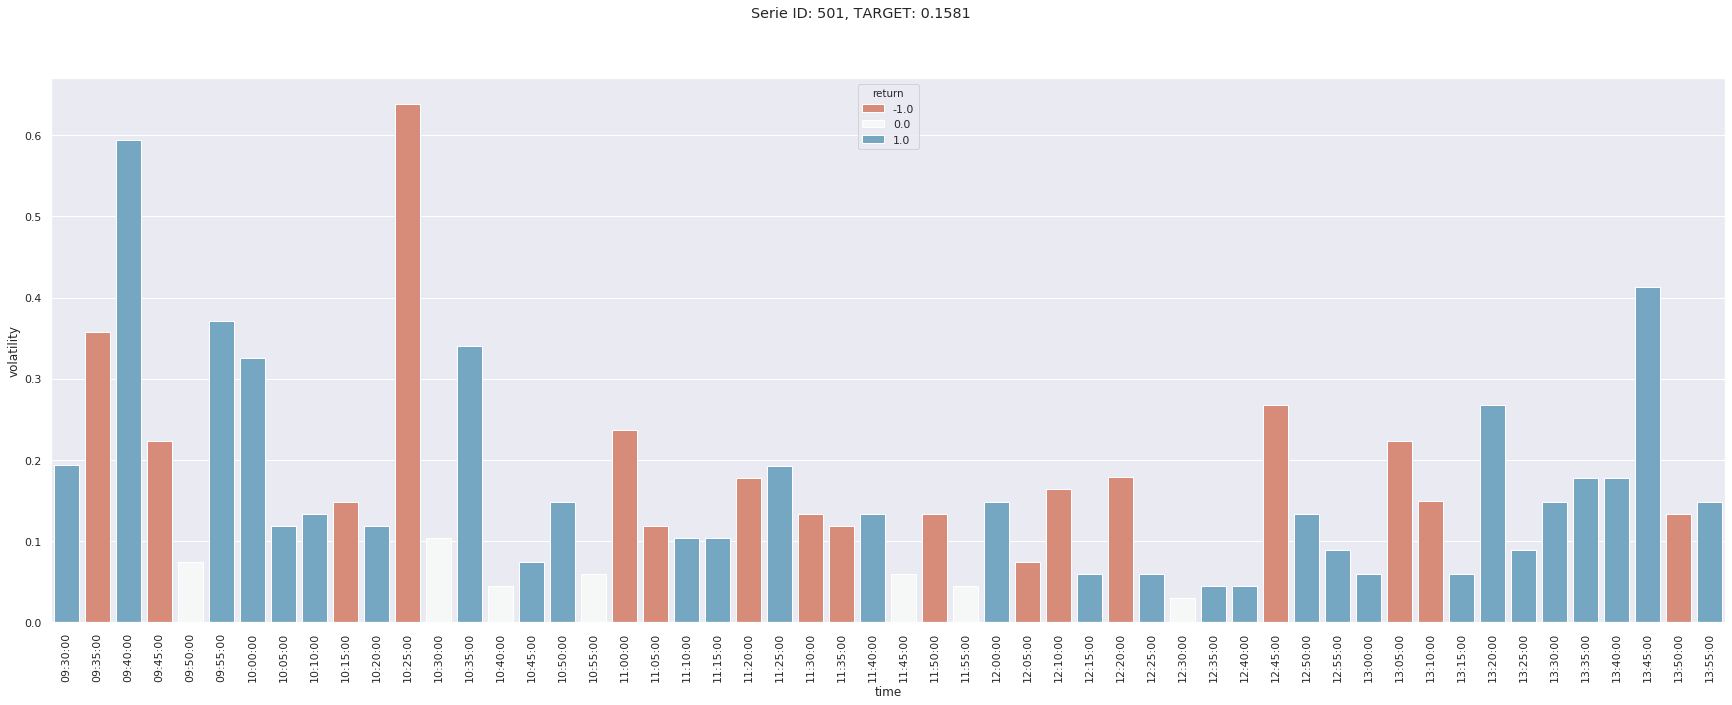

In [5]:
for ts_row in [57, 1999, 500]:
    ts_example = pd.DataFrame({
        "volatility": train_raw.iloc[ts_row, 3:57].values,
        "return": train_raw.iloc[ts_row, 57:111].values,
        "time": train_raw.columns[3:57].str[-8:],
    })

    plt.figure(figsize=(30, 10))
    sns.barplot("time", "volatility", hue="return", palette="RdBu", dodge=False, data=ts_example)
    plt.suptitle(f"Serie ID: {train_raw['ID'].iloc[ts_row]}, TARGET: {train_raw['TARGET'].iloc[ts_row]:.4}")
    plt.xticks(rotation=90);



En étudiant la distribution des volatilités conditionnellement à l'heure de la journée, on remarque ainsi, comme espéré, une très forte volatilité moyenne en début de séance.

L'affichage des outliers a été désactivé dans ce boxplot par soucis de visibilité. Les points triangulaires verts repésentent la moyenne de volatilité pour l'horaire considéré.



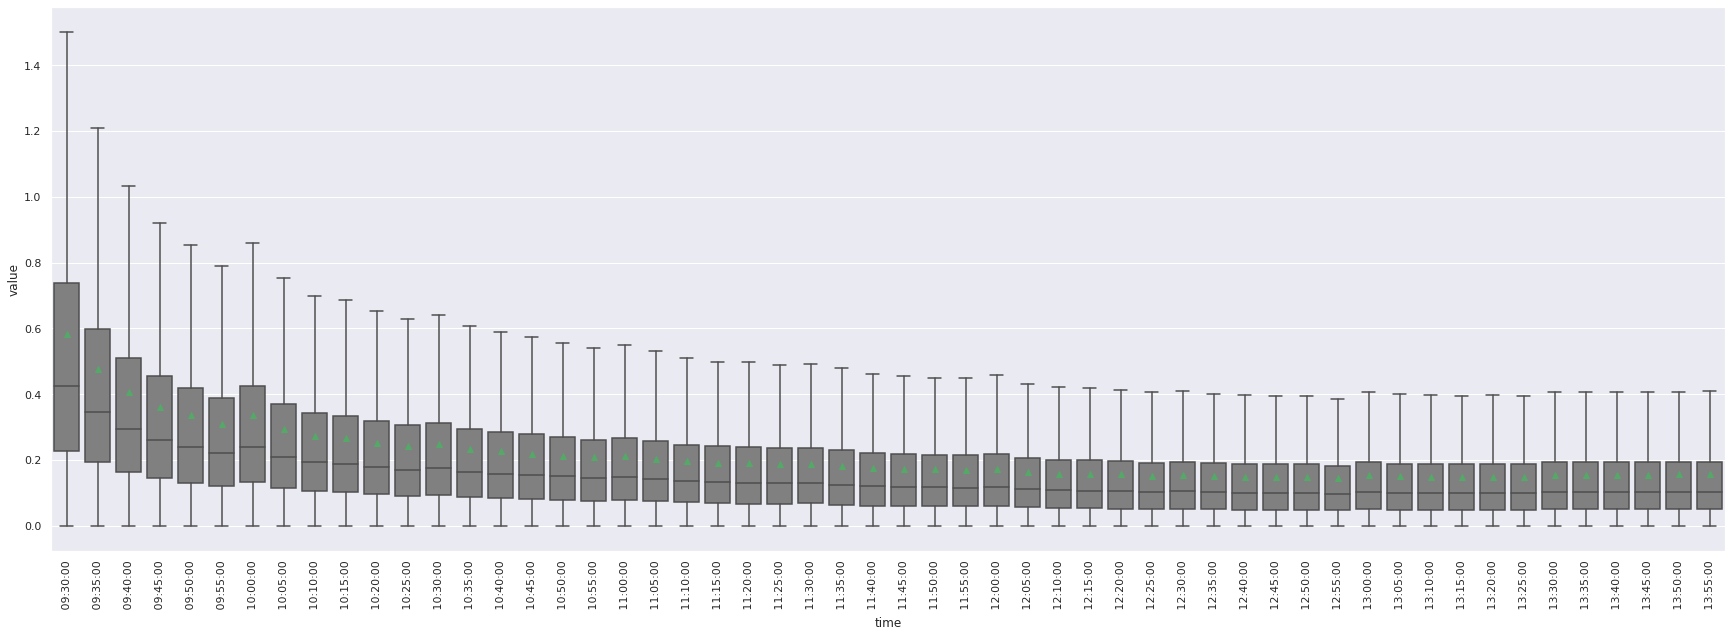

In [164]:
"""
ts_mean = train_raw.mean()
ts_mean_frame = pd.DataFrame({
    "volatility": ts_mean.iloc[3:57].values,
    "return": ts_mean.iloc[57:111].values,
    "time": ts_mean.index[3:57].str[-8:],
    })

plt.figure(figsize=(30, 10))
sns.barplot("time", "volatility", data=ts_mean_frame)
plt.suptitle(f"Serie ID: {train_raw['ID'].iloc[ts_row]}, TARGET: {train_raw['TARGET'].iloc[ts_row]:.4}")
plt.xticks(rotation=90);
"""
volatilities_per_time_span = train_raw[train_raw.columns[train_raw.columns.str.contains("volatility")]].melt()
volatilities_per_time_span["time"] = volatilities_per_time_span["variable"].str[10:].astype("category")

volatilities_per_time_span = volatilities_per_time_span.sort_values("time")

plt.figure(figsize=(30, 10))
sns.boxplot(x="time",
              y="value",
              order=volatilities_per_time_span["time"].drop_duplicates(),
              showmeans=True,
              showfliers = False,
              color="grey",
              data=volatilities_per_time_span)
plt.xticks(rotation=90);

#### Distribution des volatilités



Nous constatons visuellement que la log-volatilité sur les deux dernières heures avant fermeture suit presque une lois de student. Cela est en adéquation avec les observations empiriques du marché financier, où la log-volatilité bien que proche de la loi gaussienne affiche cependant un phénomène de fat-tail.


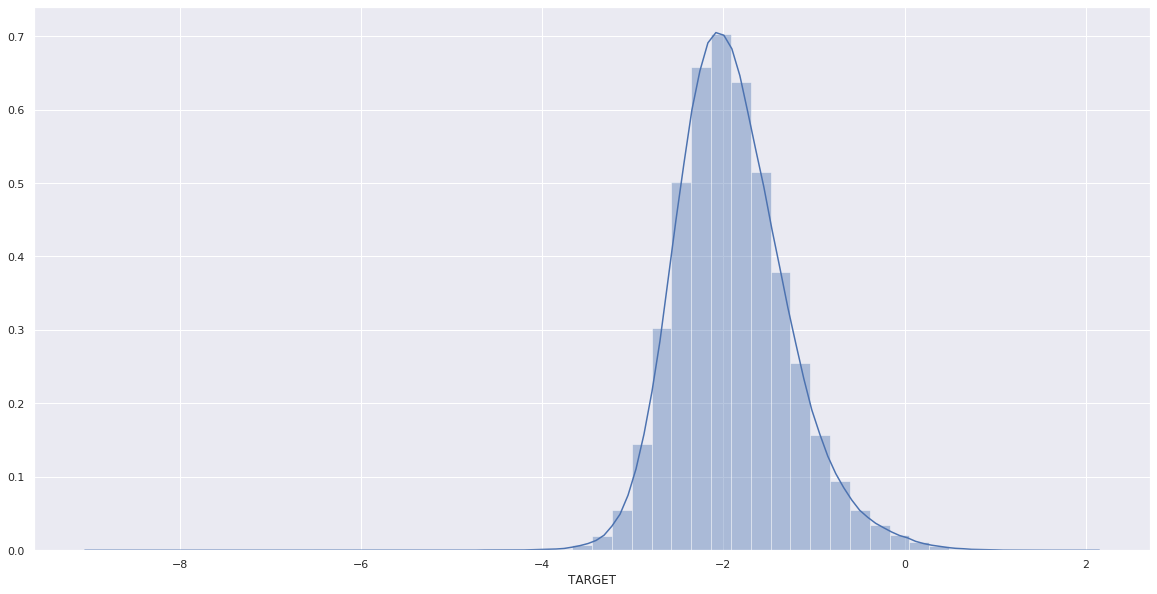

In [7]:
plt.figure(figsize=(20, 10))
sns.distplot(np.log(train_raw["TARGET"]));



De même, si on regarde les log-volatilités du matin, on obtient des distributions identiques en enlevant les sur-représentations en 0.


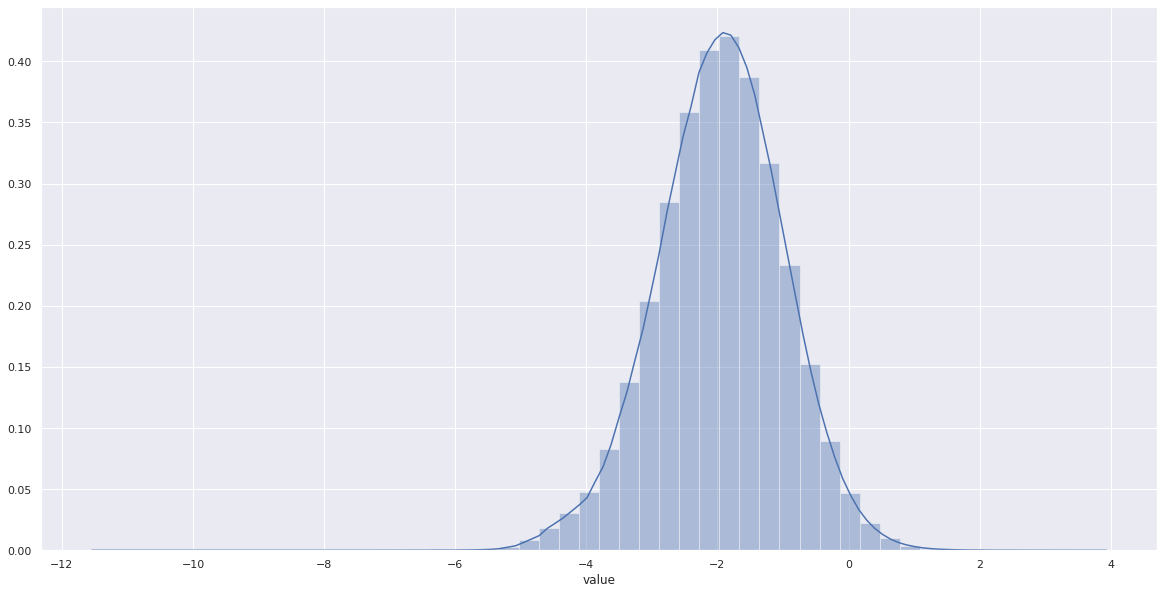

In [8]:
plt.figure(figsize=(20, 10))
sns.distplot(np.log(train_raw[vol_cols].melt().query("value > 0")["value"].dropna()));



Nous pouvons constater que la volatilité est nulle pour 4% des features :


In [9]:
train_raw[vol_cols].melt()["value"].eq(0).agg(["sum", "mean"]).to_frame()

value
sum   1.565805e+06
mean  4.556938e-02



Notons aussi la proportion de valeurs manquantes :


In [10]:
train_raw[vol_cols].melt()["value"].isna().agg(["sum", "mean"]).to_frame()

value
sum   419817.000000
mean       0.012218



Malheureusement, il est particulièrement difficile d'utiliser cet observation afin d'améliorer un modèle minimisant la MAPE.


### Données Manquantes



Un des problèmes majeurs relatif aux données est la présence de nombreuses valeurs manquantes, aussi bien au niveau des features de chaque actif, que de la répartion des produits par date. L'absence de features s'explique pour deux raisons principales :

* Instabilité du cours qui oblige la suspension de la quotation, mais cela reste particulièrement rare.
* Aucun mouvement du cours, ce qui fait qu'il n'y a pas de mise a jour du prix du titre, ce qui indiquerait la présence de produits illiquides.

Pour l'imputation de ces données, nous avons adopté une interpolation linéaire pour les volatilités. Concernant les retours manquants, considérant la difficulté de les prédire de part l'aspect tout à fait aléatoire des retours des prix de marchés décrit dans la littérature, nous choisissons de fixer leur valeur à 0.

Un autre phénomène remarquable est présent au sein des données: pour certaines dates, certains produits sont manquants.

La encore, nous pouvons le justifier par:

* action non encore quotée à la date donnée, ou retirée des marchés électroniques.
* produit totalement illiquide à une date donnée.
* volatilité nulle sur les deux heures qui impliquerait une inconsistence avec la métrique



#### Lien entre date et produit manquants



Afin de confirmer l'hypothese d'une très forte corrélation entre un ensemble de date et un ensemble de produits, nous calculons une matrice de presence entre produit et date et clusterisons cette matrice.

On remarque ci-bas en effet que sur l'ensemble d'entrainement les produits manquants sont concentrés sur un ensemble de date particulières.



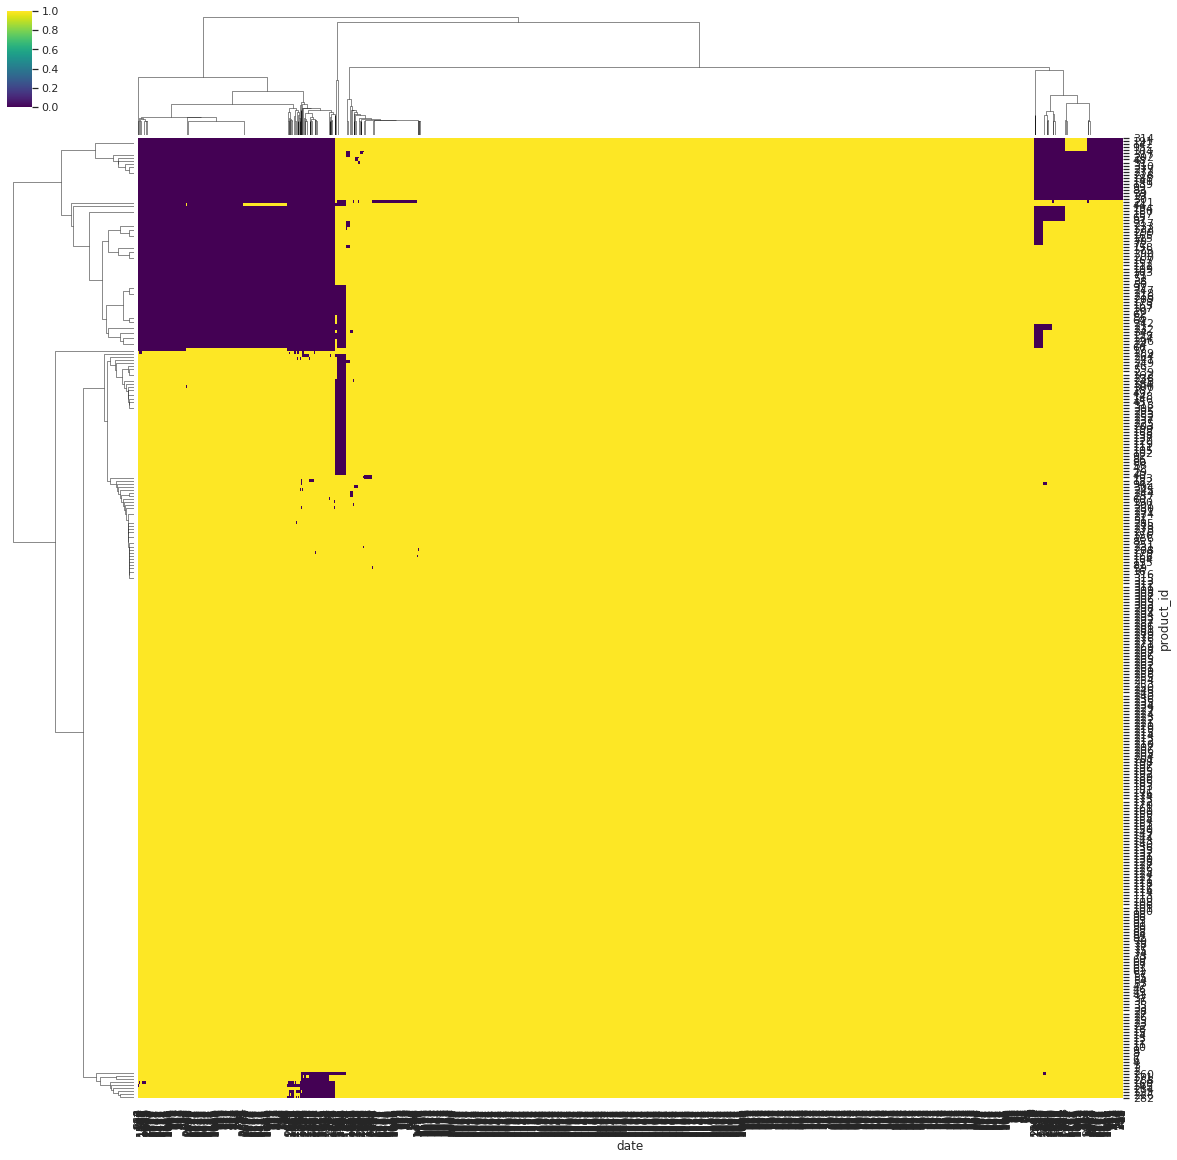

In [11]:
cross_product_date_train = pd.crosstab(train_raw["product_id"], train_raw["date"])
sns.clustermap(cross_product_date_train,
              figsize=(20, 20),
              xticklabels=True,
             yticklabels=True,
              cmap="viridis");

#### Volatilités manquantes



Le graphe suivant a pour vocation de confirmer qu'en majorité les produits avec des proportions de valeurs manquantes élevés pour un jour donné sont ceux qui sont très peu liquide ce même jour.


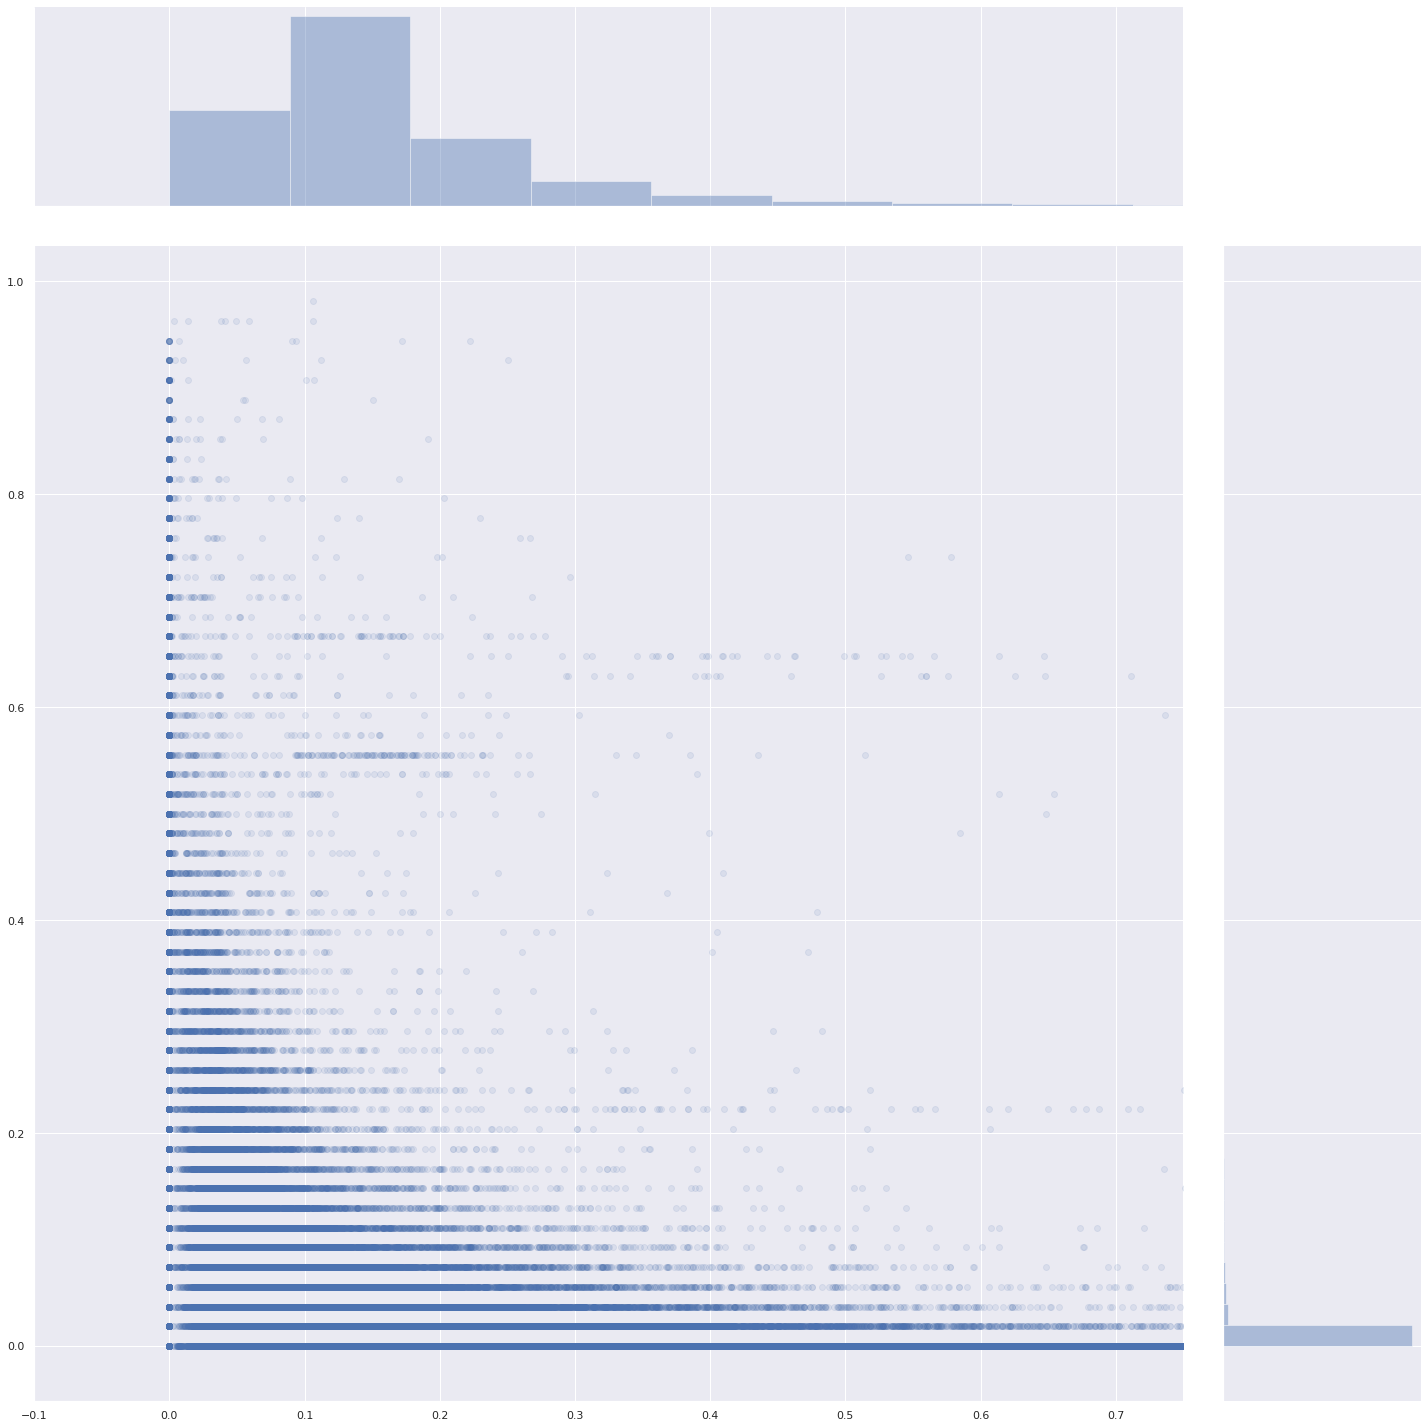

In [12]:
sns.jointplot(train_raw[vol_cols].median(axis=1),
              train_raw[vol_cols].isna().mean(axis=1),
              xlim=(-0.1, 0.75),
              alpha=0.1,
              height=20);



Nous clusterisons la matrice qui à chaque produit et date associe la proportion de predicteurs manquants.


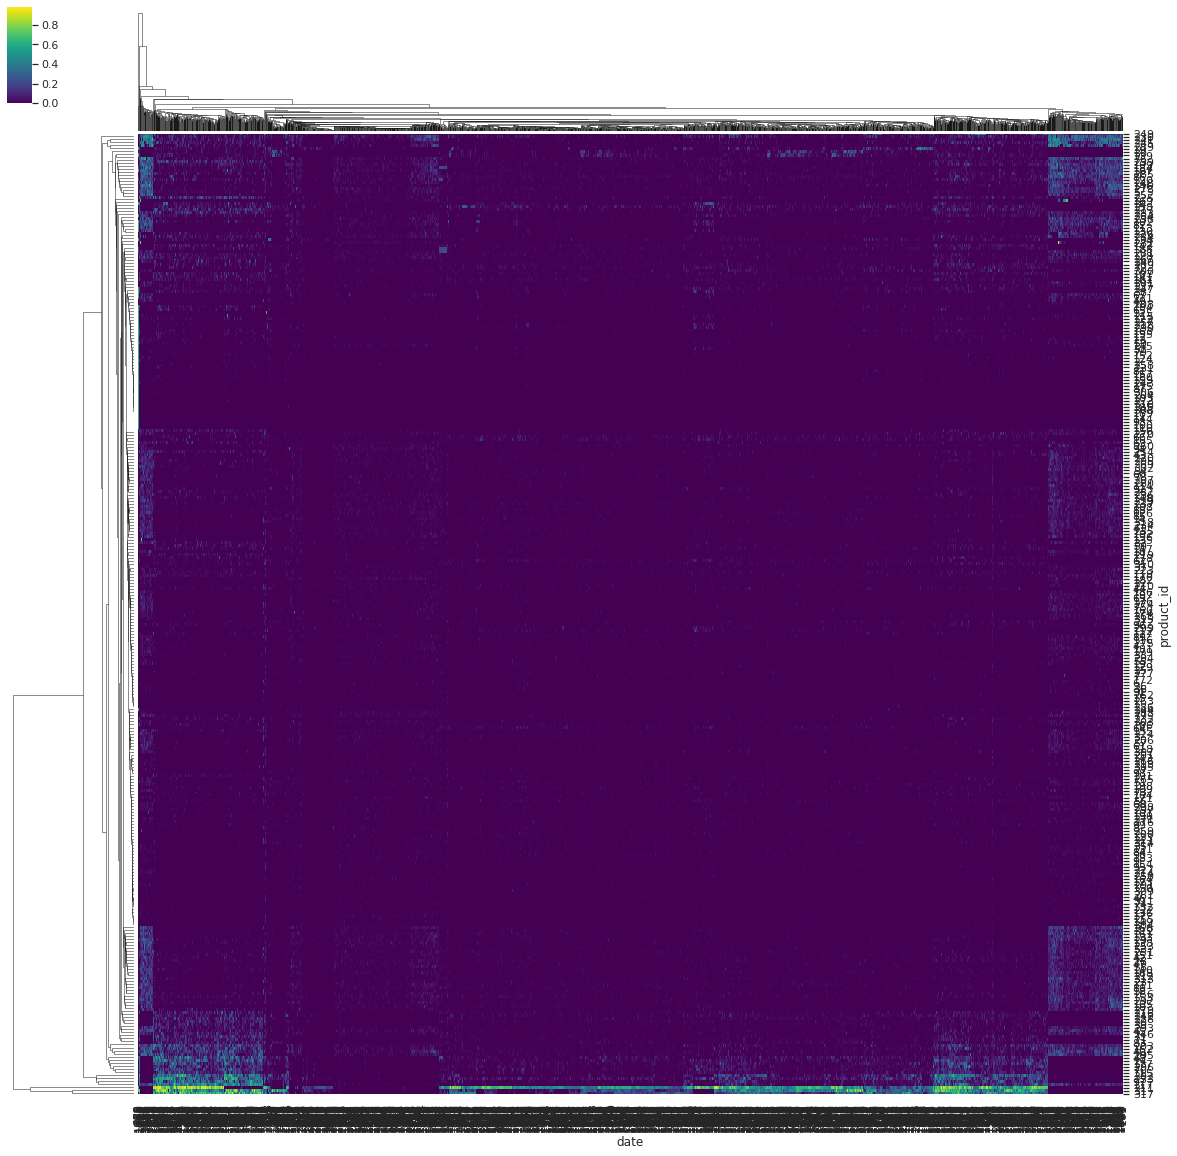

In [13]:
missing_prop_product_cross_date = pd.concat([train_raw[vol_cols].isna().mean(axis=1).rename("missing_prop"), train_raw[["product_id", "date"]]], axis=1).pivot_table(index="product_id", columns="date", values="missing_prop")

sns.clustermap(missing_prop_product_cross_date.fillna(0),
               figsize=(20, 20),
               xticklabels=True,
               yticklabels=True,
               cmap="viridis");

## Modèles Baselines

**Dans toute la suite, nous considérons 80% de nos données d'entrainement comme ensemble de train, et 20% de nos données d'entrainement comme ensemble de validation. Ce partionnement est fixe pour tous les modèles, de par l'utilisation de la même seed pour réaliser le partionnement.**

Nous présentons ici trois modèles baselines :

In [165]:
# helper functions for predictions analysis
is_in_validation = pd.read_csv("misc/is_in_validations.csv")["rnd"]
indexes = pd.read_csv("misc/wide_indexes.csv")

split = indexes.copy()
split.replace(0, -1, inplace=True)

for col in split:
    split.loc[indexes[col].ne(0), col] = is_in_validation.values[:indexes[col].ne(0).sum()]

id_to_is_in_validation = pd.DataFrame.from_dict({
    "ID": indexes.values.flatten(),
    "is_in_validation": split.values.flatten()
}).query("ID != 0").set_index("ID")["is_in_validation"]

def load_predictions(path):
    predictions = pd.read_csv(path)
    compute_mape(predictions)
    
    predictions["is_in_validation"] = predictions["ID"].map(id_to_is_in_validation)

    train = predictions[predictions["is_in_validation"].eq(0)]
    val = predictions[predictions["is_in_validation"].eq(1)]
    
    return train, val

def compute_mape(predictions):
    predictions["product_id"] = predictions["product_id"].astype("category")

    predictions["sign_mape"] = (predictions["TARGET"] - predictions["predict"]) / predictions["TARGET"] * 100
    predictions["mape"] = predictions["sign_mape"].abs()

def compute_mape_product(train_predictions, valid_predictions):
    return pd.Series({
    "train": train_predictions["mape"].mean(), 
    "validation": valid_predictions["mape"].mean()
    }, name="MAPE").to_frame()

def plot_mape_v_rank(train_predictions, valid_predictions):
    fig, (train_ax, valid_ax) = plt.subplots(ncols=2, figsize=(20, 7.5))
    fig.suptitle("MAPE par produit / Rang")
    train_predictions.groupby("product_id")["mape"].mean().sort_values().reset_index(drop=True).plot.line(title="Train", ax=train_ax);
    valid_predictions.groupby("product_id")["mape"].mean().sort_values().reset_index(drop=True).plot.line(title="Valid", ax=valid_ax);

def boxplot_mape_per_product(predictions):
    plt.figure(figsize=(30, 10))
    mape_per_product_id = predictions.groupby("product_id")["mape"].mean().sort_values()
    sns.boxplot(x="product_id",
            y="mape",
            order=mape_per_product_id.index,
            showmeans=True,
            showfliers = False,
            linewidth=0.1,
            width=0.5,
            data=predictions);
    plt.xticks(rotation=90, size=5)

def top_5_worst_product(predictions):
    return predictions.groupby("product_id")["mape"].mean().sort_values(ascending=False).head(5).reset_index()

def pred_greater_than_2000(predictions):
    return predictions.query("mape > 2000")[["predict", "TARGET", "mape", "product_id"]]

### Mediane des Volatilités du Matin




Le premier modèle que l'on propose n'est autre que la médiane des volatilités du matin, qui obtient le score suivant après soumission à CFM :


In [15]:
median_benchmark = pd.DataFrame({
                    "ID": test_raw["ID"],
                    "TARGET": test_raw[vol_cols].median(axis=1)
})

In [51]:
score_median = submit_dataframe(median_benchmark)
score_median

26.4254

### Régression Élastic-Net basique

Comme premier modèle, nous choisissons d'effectuer une simple régression elastic-net sur toutes les features, et sans transformation des features si ce n'est d'interpoler les volatilités manquantes. Nous considèrons 80% de nos données comme jeu d'entrainement, et 20% d'entre elles comme jeu de validation.

Après différents essais, et cela sera d'ailleurs le cas dans tous les modèles suivants, nous constatons que les retours ont un pouvoir prédictif nuls. Nous considérons alors comme features uniquement la moyenne de ces retours sur la journée, ainsi que les volatilités.

Afin d'essayer de se rapprocher de la MAPE, nous pondérons nos pertes quadratiques par $(TARGET)^{(-3/2)}$. Nous effectuons par ailleurs une recherche de la pénalisation optimale sur le jeu de validation.

In [17]:
train_predictions_elastic_simple, valid_predictions_elastic_simple = load_predictions("results/predictions_glm_all_assets.csv")

Nous obtenons les MAPE suivantes sur le jeu de train et sur le jeu de validation.

In [18]:
compute_mape_product(train_predictions_elastic_simple, valid_predictions_elastic_simple)

MAPE
train       25.193831
validation  26.238252

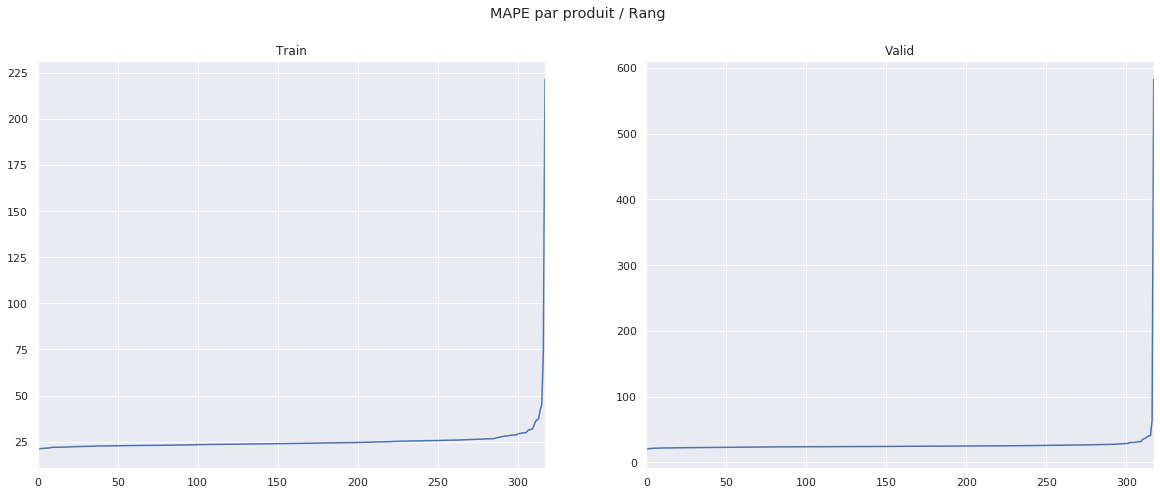

In [19]:
plot_mape_v_rank(train_predictions_elastic_simple, valid_predictions_elastic_simple)



Comme constaté plus haut, le comportement de notre modèle est très variable en fonction de l'actif sur lequel il effectue les prédictions. Cela n'a rien d'étonnant car notre modèle ne prend pas en compte la structure particulière de chaque actif. Nous remarquons sur le boxplot suivant qu'un actif en particulier, le 211, provoque régulièrement une erreur extrême de prédiction (au sens de la MAPE). Après étude, il s'avère que le nombre d'erreurs extrêmes de prédiction est corrélé au pourcentage de features de volatilité manquante. Les features de l'actif 211, pour exemple, sont manquantes à plus de 50%.


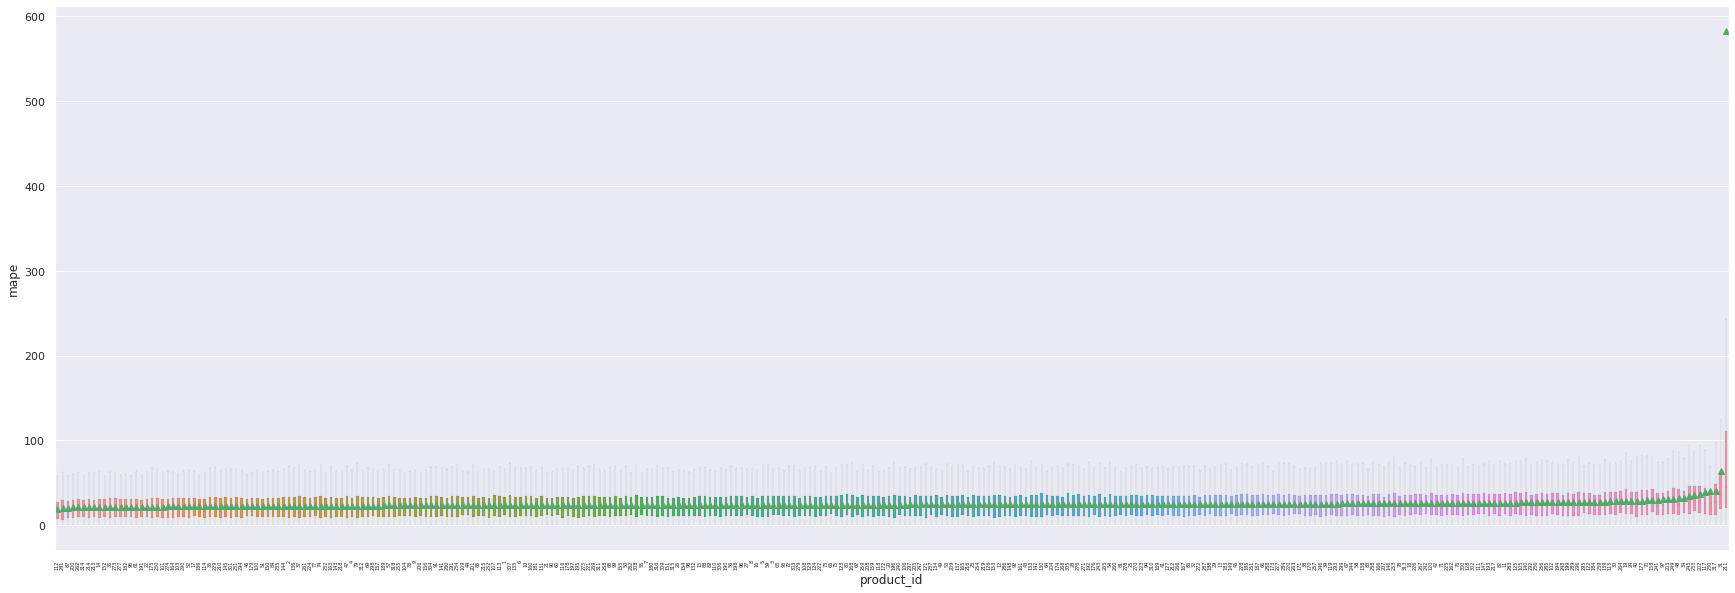

In [166]:
boxplot_mape_per_product(valid_predictions_elastic_simple)

Ici nous affichons les prédictions qui ont une MAPE supérieure à 2000: 

In [21]:
pred_greater_than_2000(valid_predictions_elastic_simple)

predict    TARGET          mape product_id
311899  0.114717  0.001008  11277.816056        211
365476  0.109641  0.000858  12685.100980        211
431366  0.087165  0.002504   3381.204884        230
444967  0.114946  0.000132  86715.917120        211
516022  0.099153  0.000578  17050.214170        211
626331  0.083922  0.000360  23198.076735        211

Ci-dessous, les 5 produits ayant la MAPE la plus élevée:

In [22]:
top_5_worst_product(valid_predictions_elastic_simple)

product_id        mape
0        211  582.764380
1         31   64.469789
2        317   40.887884
3        230   40.219172
4        117   39.270925

En soumettant à CFM nos prédictions effectuées sur le jeu de test, nous obtenons une MAPE de :

In [52]:
score_elastic_simple = submit("results/test_predictions_glm_all_assets.csv")
score_elastic_simple

25.2709

### Gradient Boosting basique



Dans la même idée que le modèle précèdent, nous entrainons un modèle Gradient Boosting (avec perte MAPE) sur toutes les données, avec les mêmes features que précèdemment. Après recherche des paramètres optimaux, notamment de taille et de profondeur des arbres, nous obtenons étonnament des résultats considérablement meilleurs.


In [24]:
train_predictions_gbm_simple, valid_predictions_gbm_simple = load_predictions("results/predictions_gbm_all_assets.csv")

In [25]:
compute_mape_product(train_predictions_gbm_simple, valid_predictions_gbm_simple)

MAPE
train       22.842474
validation  23.265244

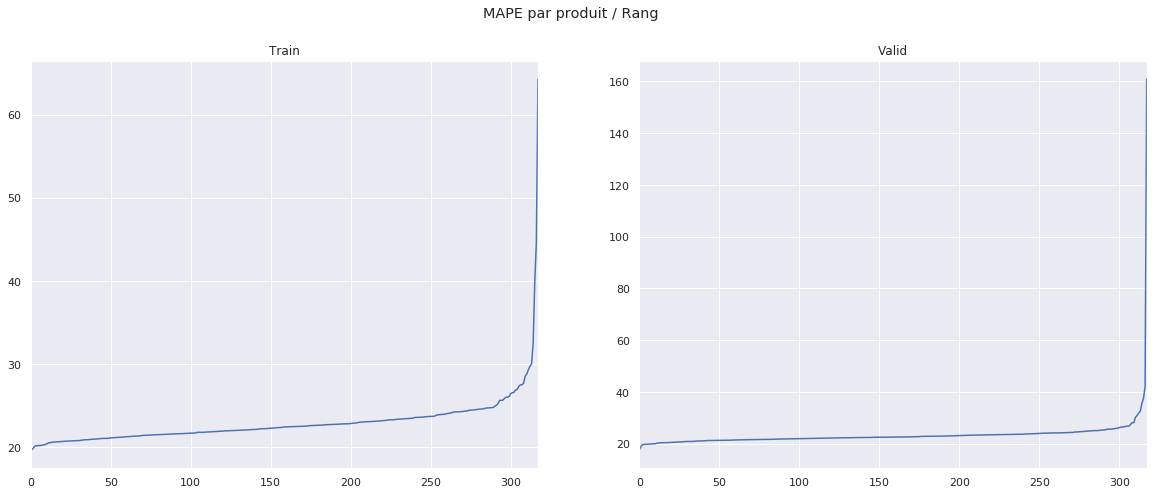

In [26]:
plot_mape_v_rank(train_predictions_gbm_simple, valid_predictions_gbm_simple)



Le même problème de non-prise en compte de la structure de chaque actif apparaît à nouveau. Concernant les erreurs extrêmes, elles sont légèrement mieux gérées que précedemment. Encore une fois, l'actif 211 fournit la plus grande variance dans l'erreur de prédiction.


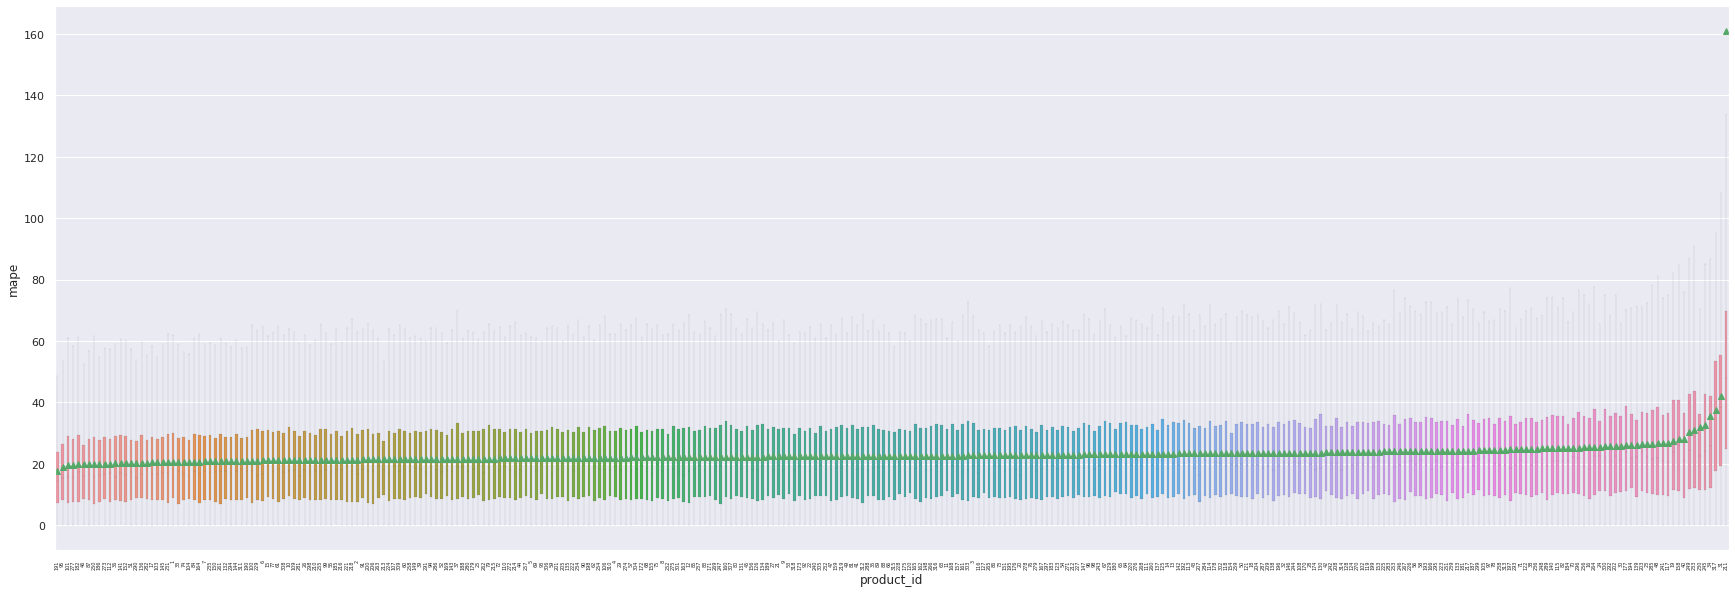

In [167]:
boxplot_mape_per_product(valid_predictions_gbm_simple)



A nouveau, voici les prédictions ayant donnée une erreur de plus de 2000 de MAPE.

In [28]:
pred_greater_than_2000(valid_predictions_elastic_simple)

predict    TARGET          mape product_id
311899  0.114717  0.001008  11277.816056        211
365476  0.109641  0.000858  12685.100980        211
431366  0.087165  0.002504   3381.204884        230
444967  0.114946  0.000132  86715.917120        211
516022  0.099153  0.000578  17050.214170        211
626331  0.083922  0.000360  23198.076735        211

Ci dessous, les produits les plus mal produit suivant la MAPE. Comme précédemment on remarque que les erreurs les plus extrêmes sont produites sur les mêmes actifs:

In [171]:
top_5_worst_product(valid_predictions_gbm_simple)

product_id        mape
0        211  160.895421
1         31   42.038608
2        317   37.570652
3         34   35.551697
4        245   32.545428

En soumettant nos résultats à CFM, nous obtenons comme nous pouvions l'espérer à la vue des erreurs d'entraînement et de validation, un résultat bien meilleur.

In [53]:
score_gbm_simple = submit("results/test_predictions_gbm_all_assets.csv")
score_gbm_simple

23.263

## Modèles avancés


Dans toute la suite, nous considérons 80% de nos données d'entrainement comme ensemble de train, et 20% de nos données d'entrainement comme ensemble de validation. Ce partionnement est fixe pour tous les modèles, de par l'utilisation de la même seed pour réaliser le partionnement.

La partie précédente nous amène à deux constats majeurs :

* Le nombre de features trop élevé provoque une instabilité dans nos prédictions.
* Il est probablement essentiel de tenir en compte de la structure de chaque actif et de la corrélation entre les actifs afin d'améliorer nos prédictions.

Dans cette optique, nous proposons trois modèles plus avancés, qui tous impliquent la création d'un modèle par actif, soit 318 sous modèles :


### Gradient Boosting actif par actif.



Nous entrainons 318 modèles GBM avec perte MAPE et recherche des paramètres optimaux, en considérant désormais pour chaque modèle les features suivantes :

* Les volatilité aggrégées toutes les 30 minutes pour l'actif considéré.
* La moyenne des volatilités de tous les actifs à la date donnée.

La principale raison pour laquelle nous avons aggrégé les features pour nous assurer que l'impact du bruit des features soit contenu.

Ce modèle nous donne une MAPE d'entraînement bien plus faible que le modèle baseline, mais étrangement une MAPE de validation très différente malgré recherche des paramètres optimaux, comme nous pouvons le constater :


In [31]:
train_predictions_gbm, valid_predictions_gbm = load_predictions("results/predictions_gbm_asset_by_asset.csv")

In [32]:
compute_mape_product(train_predictions_gbm, valid_predictions_gbm)

MAPE
train       16.212051
validation  24.443161

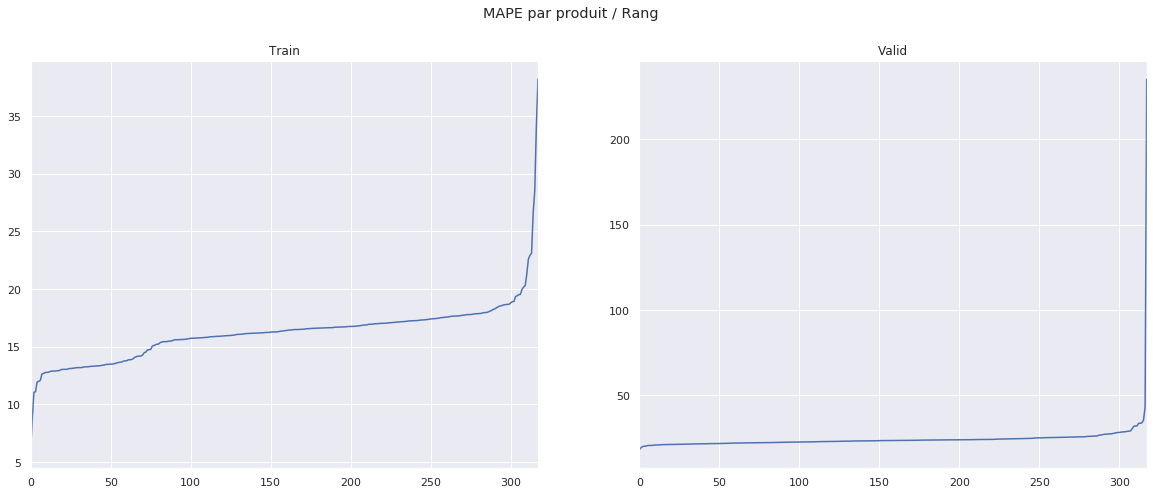

In [33]:
plot_mape_v_rank(train_predictions_gbm, valid_predictions_gbm)

A nouveau, nous obtenons des erreurs extrêmes sur certains produits, en lien avec la proportion de features manquantes.

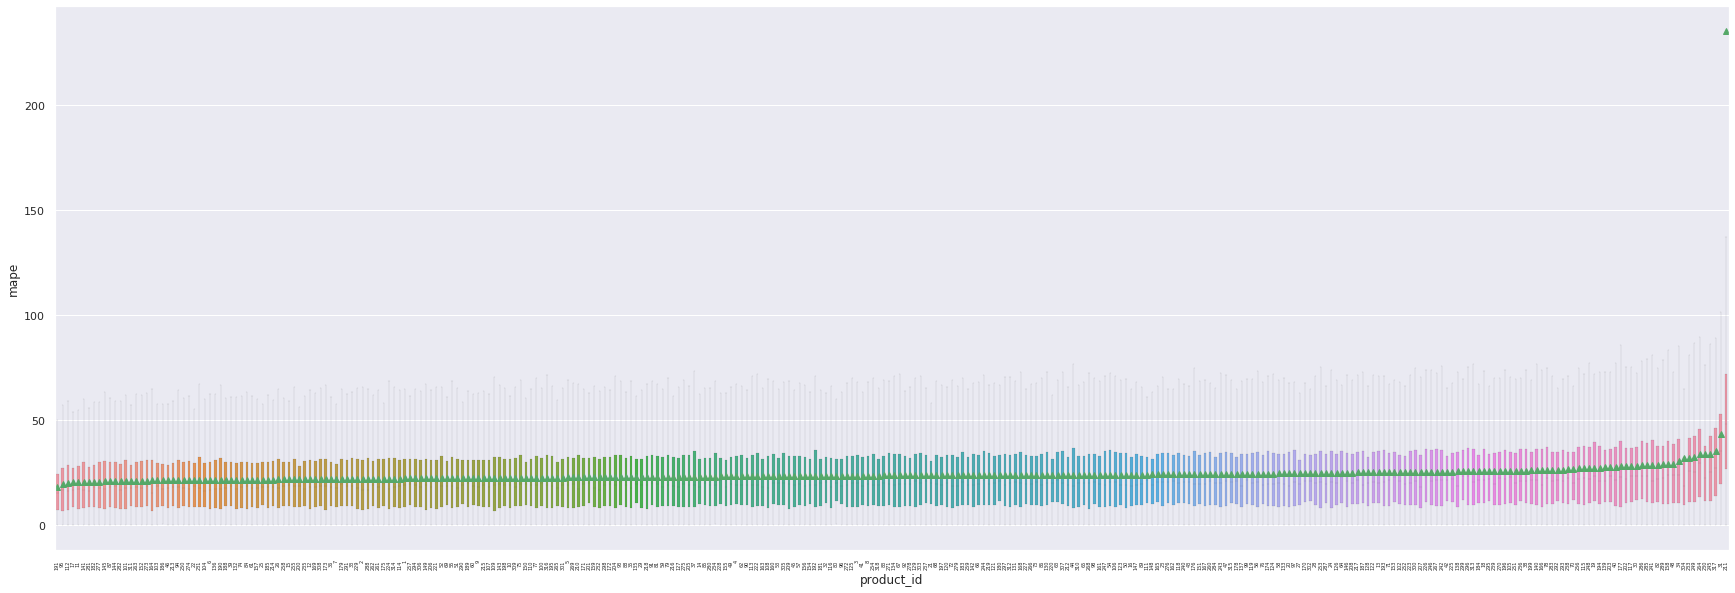

In [168]:
boxplot_mape_per_product(valid_predictions_gbm)

In [35]:
top_5_worst_product(valid_predictions_gbm)

product_id        mape
0        211  235.049374
1         31   43.271284
2        317   35.506672
3        245   33.969012
4        230   33.734906

En soumettant nos prédictions à CFM, nous obtenons une MAPE de :

In [55]:
score_gbm_asset_by_asset = submit("results/test_predictions_gbm_asset_by_asset.csv")
score_gbm_asset_by_asset

23.9384

### Wide Adaptative Elastic-Net

L'idée de ce modèle est de pallier à l'absence de prise en compte de la corrélation entre actifs par le modèle linéaire baseline. Nous entrainons, pour chaque actif product_id, un modèle distinct.


En premier lieu, nous effectuons pour chaque actif product_id une liste contenant les actifs qui sont absent, dans le jeu d'entrainement, pour au moins une date durant laquelle product_id est présent. En considérant tous les actifs sauf ceux listés, nous obtenons ainsi pour chaque product_id, un "bloc" d'actifs constant à chaque date.

Une fois ce bloc obtenu, nous considérons les features suivantes :

* Moyenne des retours pour chaque actif du bloc.
* Volatilité aggrégée toutes les 30 minutes pour chaque actif du bloc.

La recherche des paramètres optimaux pour chacun de ses 318 modèles nous donne que la pénalisation Ridge est privilégiée. Cette recherche s'effectue ainsi :

* Pour une liste de $p$ entre $0$ et $1$ (p représentant la pondération entre les pénalisations $l^1$ et $l^2$), rechercher le $h$ (coefficient de pénalisation optimal) qui minimise la MAPE sur le jeu de validation. Cette recheche se fait en remontant le chemin de régularisation qu'utilise H2O pour trouver $h$.
* Pour chaque $p$, comparer les modèles obtenus par la procèdure précèdente.

La prédiction actif par actif en utilisant cette procèdure nous donne les MAPE suivantes.

In [37]:
train_predictions_wide_adaptative, valid_predictions_wide_adaptative = load_predictions("results/predictions_wide_adaptative_asset_by_asset.csv")

In [38]:
compute_mape_product(train_predictions_wide_adaptative, valid_predictions_wide_adaptative)

MAPE
train       19.285098
validation  23.174364

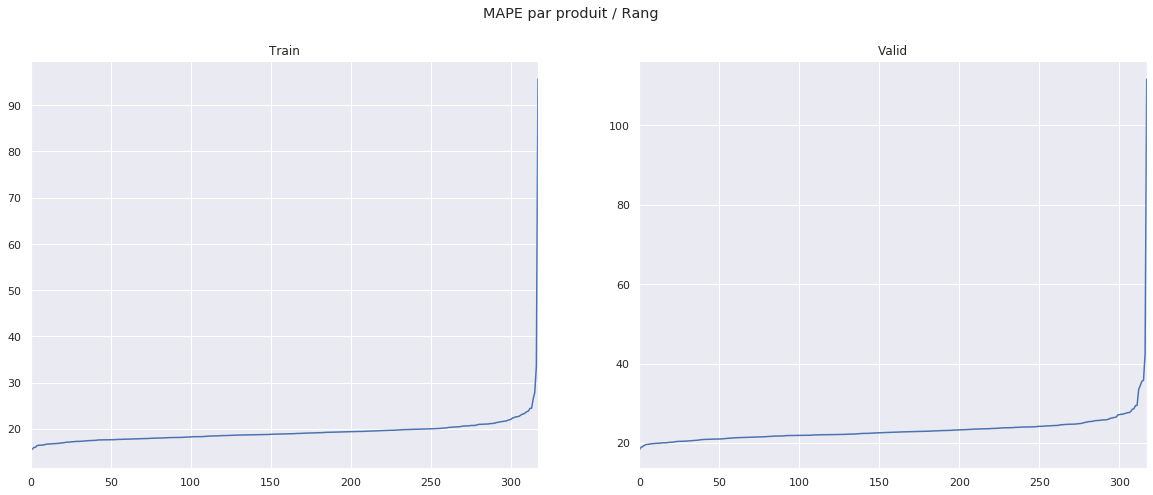

In [39]:
plot_mape_v_rank(train_predictions_wide_adaptative, valid_predictions_wide_adaptative)

Nous pouvons constater que les produits atypiques sont bien mieux gérés avec ce modèle. Cela s'explique par le fait que l'utilisation de la corrélation entre les actifs permet de diminuer l'impact des valeurs manquantes pour les produits dont les features sont regulièrement imputées.

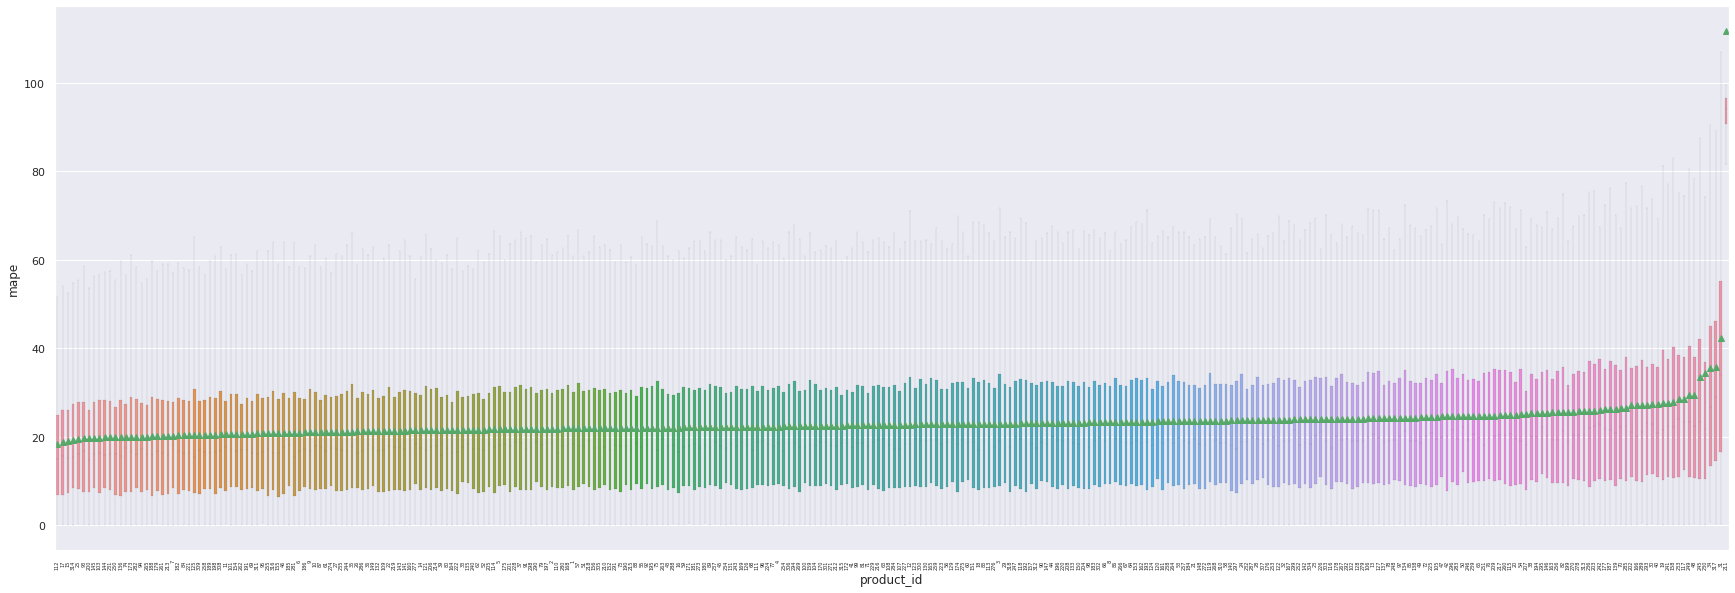

In [169]:
boxplot_mape_per_product(valid_predictions_wide_adaptative)

Si d'autant les actifs problématiques restent les mêmes, nous remarquons que leur MAPE reste contenue comparée aux modèles précedents. 

In [41]:
top_5_worst_product(valid_predictions_wide_adaptative)

product_id        mape
0        211  111.673404
1         31   42.371464
2        317   35.789674
3         34   35.535126
4        230   34.435568

La soumission de nos résultats à CFM donne le résultat suivant :

In [56]:
score_wide_adaptative_asset_by_asset = submit("results/test_predictions_wide_adaptative_asset_by_asset.csv")
score_wide_adaptative_asset_by_asset

23.1077

### Quantile Regression

Conditionnellement au `product_id`, nous avons effectué une regression quantile, avec une perte MAPE, de la volatilité cible par rapport aux features suivantes :

* Volatilités de product_id aggrégées toutes les 30 minutes.
* Moyenne de la volatilité de tous les actifs pour une date donnée.

La principale raison pour laquelle nous avons aggrégé les features pour nous assurer que l'impact du bruit des features soit contenu. L'absence de pénalisation dans l'implémentation de la Régression Quantile
rend, d'après nos expérimentations, cette aggrégation essentielle à la qualité de prédiction du modèle.

In [43]:
train_predictions_quantile, valid_predictions_quantile = load_predictions("results/predictions_quantile_asset_by_asset.csv")

On dispose des scores suivants sur l'ensemble de train et de validation (80%-20%) : 

In [44]:
compute_mape_product(train_predictions_quantile, valid_predictions_quantile)

MAPE
train       21.738562
validation  22.292690

Comme on peut le constater sur les graphiques suivants, on remarque que le score obtenu par notre méthode
est à nouveau très variable en fonction de l'actif considéré.

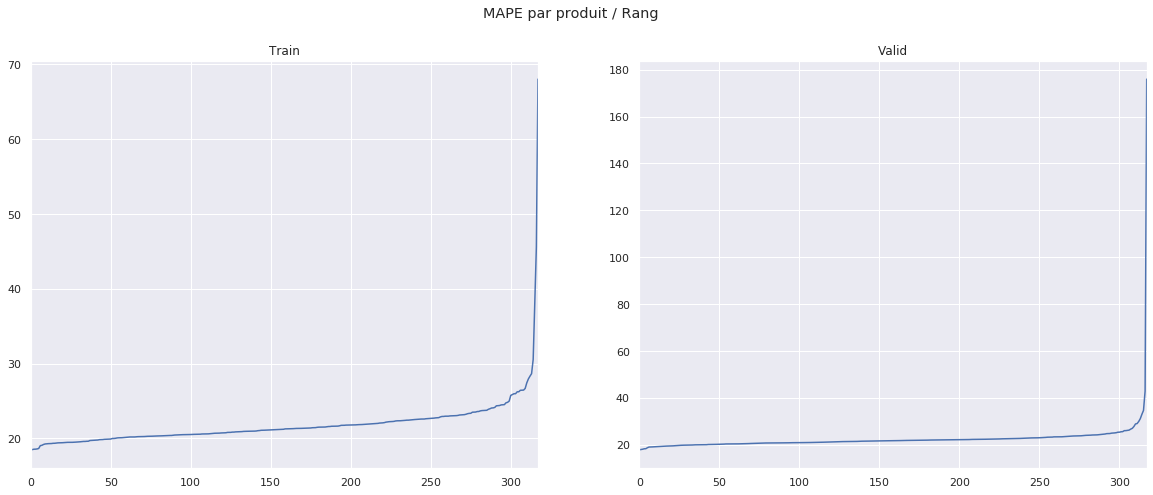

In [45]:
plot_mape_v_rank(train_predictions_quantile, valid_predictions_quantile)

Cette variabilité des résultats peut, comme en témoigne le boxplot suivant, être en partie expliquée par la variabilité du nombre d'erreurs extrêmes de prédiction en fonction de l'actif considéré.

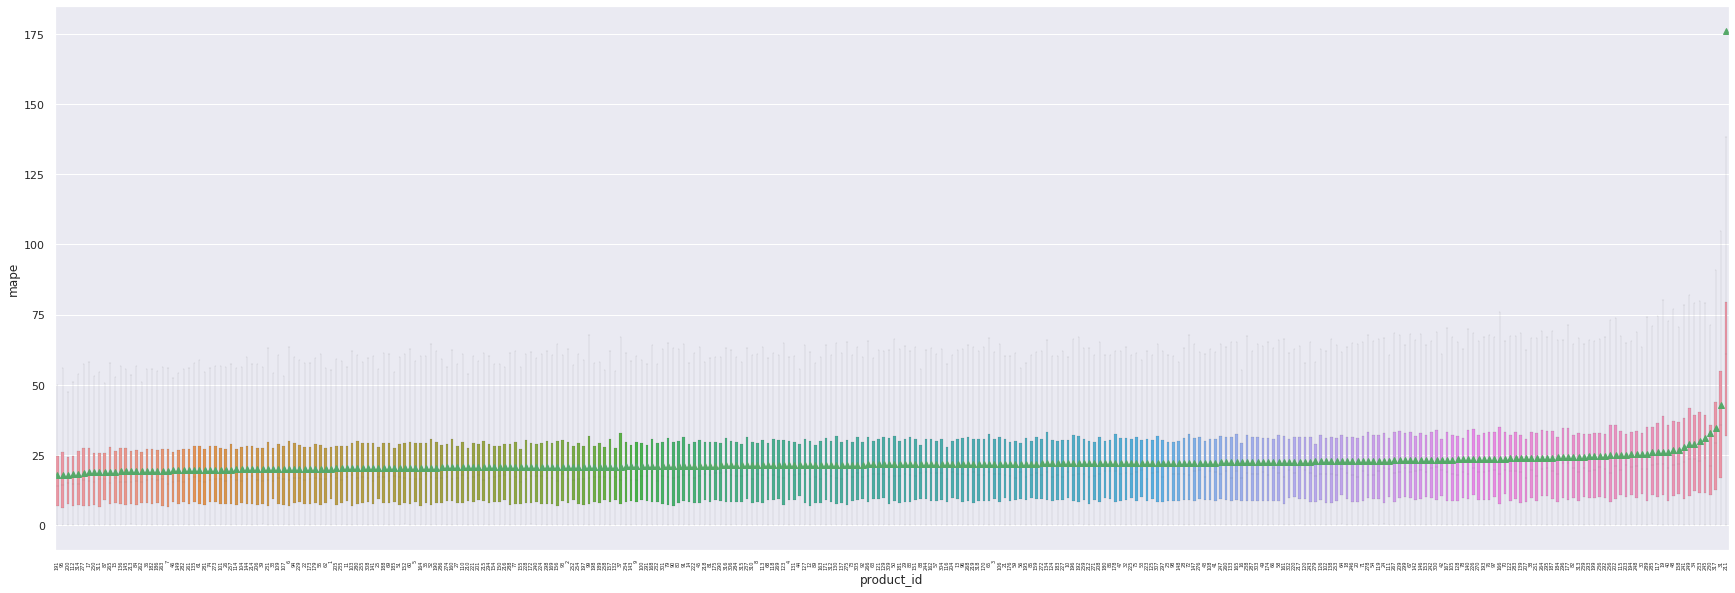

In [170]:
boxplot_mape_per_product(valid_predictions_quantile)

A nouveau, les 5 produits les moins bien prédits donnent des scores faussant considérablement notre MAPE totale.

In [47]:
top_5_worst_product(valid_predictions_quantile)

product_id        mape
0        211  175.990856
1         31   42.835842
2        317   34.600058
3        230   32.935099
4        245   31.085524

En soumettant nos prédictions du jeu de test à CFM, nous obtenons la MAPE suivante, qui est de loin la meilleure obtenue jusqu'à présent :

In [57]:
score_quantile_asset_by_asset = submit("results/test_predictions_quantile_asset_by_asset.csv")

### Aggregation



Nous décidons d'essayer d'aggréger nos trois modèles avancés en effectuant une regression quantile sur leurs prédictions.

Pour cela, nous entrainons notre régression sur toutes les prédictions effectuées sur le jeu de validation, et nous appliquons ce modèle aux prédictions obtenues sur le jeu de test. Cela nous donne, après soumission des résultats à CFM, la MAPE suivante sur le jeu de test:


In [49]:
def create_aggregation_frame(*,gbm,quantile,wide_adaptative):
    for col in ["product_id", "ID"]:
        assert pd.concat([gbm[col],
                          quantile[col],
                          wide_adaptative[col]],
                         axis=1).var(axis=1).le(0.0001).all()
    
    return pd.DataFrame({
        "gbm": gbm["predict"],
        "quantile": quantile["predict"],
        "wide_adaptative": wide_adaptative["predict"],
        "ID": gbm["ID"],
        "product_id": gbm["product_id"],
    })

In [49]:
# Training
valid_aggregation_frame = create_aggregation_frame(gbm=valid_predictions_gbm,
                                                   quantile=valid_predictions_quantile,
                                                   wide_adaptative=valid_predictions_wide_adaptative)

aggregation_qr = QuantileLinearRegression()
aggregation_X = valid_aggregation_frame[["gbm", 
                                         "quantile",
                                         "wide_adaptative"]]
aggregation_y = valid_predictions_gbm[ "TARGET"]

aggregation_weights = aggregation_y.pow(-1)

aggregation_qr.fit(aggregation_X, aggregation_y, sample_weight=aggregation_weights)

aggregation_valid_predictions = aggregation_qr.predict(aggregation_X)

aggregations_valid_score = ((aggregation_y - aggregation_valid_predictions)/aggregation_y).mean()

In [61]:
# Prediction
test_id_to_product = test_raw.set_index("ID")["product_id"]

test_predictions_gbm = pd.read_csv("results/test_predictions_gbm_asset_by_asset.csv")
test_predictions_wide_adaptative = pd.read_csv("results/test_predictions_wide_adaptative_asset_by_asset.csv")
test_predictions_quantile = pd.read_csv("results/test_predictions_quantile_asset_by_asset.csv")

for test_df in [test_predictions_gbm, test_predictions_wide_adaptative, test_predictions_quantile]:
    test_df.rename(columns={"TARGET": "predict"}, inplace=True)
    test_df["product_id"] = test_df["ID"].map(test_id_to_product)

test_aggregation_frame = create_aggregation_frame(gbm=test_predictions_gbm,
                                                  quantile=test_predictions_quantile,
                                                  wide_adaptative=test_predictions_wide_adaptative)

aggregation_test_X = test_aggregation_frame[[
    "gbm", 
    "quantile", 
    "wide_adaptative"]]

aggregation_test_predict_raw = aggregation_qr.predict(aggregation_test_X)
aggregation_test_predict = pd.DataFrame.from_dict({
        "ID": test_aggregation_frame["ID"],
        "TARGET": aggregation_test_predict_raw.clip(0)
    })

aggregation_dataframe_submission = aggregation_test_predict.sort_values("ID")

In [63]:
score_aggregation = submit_dataframe(aggregation_dataframe_submission)
score_aggregation

21.3592

## Conclusion/Score par modèle

In [159]:
resume_score = pd.Series({
    "Médiane Volatilité Matin": score_median,
    "Régression Élastic-Net Basique": score_elastic_simple,
    "Gradient Boosting Basic": score_gbm_simple,
    "Gradient Boosting Actif par Actif": score_gbm_asset_by_asset,
    "Wide Adaptative Elastic-Net": score_wide_adaptative_asset_by_asset,
    "Régression Quantile": score_quantile_asset_by_asset,
    "Aggrégation": score_aggregation
},
name="Score")

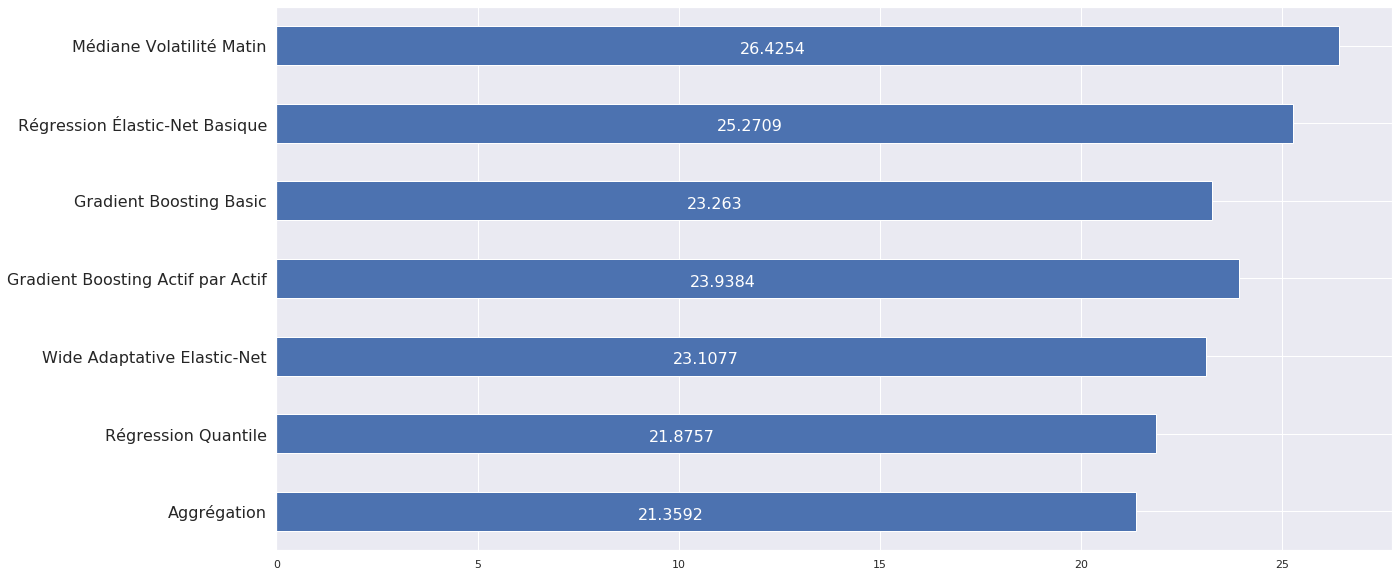

In [160]:
f, ax = plt.subplots(figsize=(20, 10))
resume_score[::-1].plot.barh(ax=ax);
for p in ax.patches:
    label = str(p.get_width())
    x = p.get_width() / 2
    y = p.get_y() + 0.1
    ax.annotate(label,(x, y),
                xytext=(-2, 4),
                textcoords='offset points',
                horizontalalignment='right',
                size=16,
               color="white")
ax.tick_params(axis="y", labelsize=16)




Voici, en comparaison, les scores obtenus par les meilleurs modèles du challenge, où les meilleurs scores sont obtenus par utilisation de réseaux de neuronnes :

1. 20.7319
2. 20.8711
3. 20.908
4. 20.9396
5. 20.9749
6. 21.1613
7. 21.1846
8. 21.1923 [CFM Model]
9. 21.2706
10. 21.2895
11. 21.2921

Notre modèle final : **21.3592**

Notre meilleur modèle obtient ainsi un score légèrement supérieur aux meilleurs modèles de cette compétition. Comme évoqué en introduction, cela nous confirme qu'il est très difficile de faire mieux que des modèles linéaires.

Certaines améliorations pourraient potentiellement être obtenues en améliorant les transformations effectuées sur les données, et en utilisant une méthode plus fine d'imputation des valeurs manquantes. De plus, la méthode wide adaptative utilisée ici semble prometteuse, et mériterait d'être testée suite à un entrainement sur un plus grand jeu de données. Dans la même idée, notre méthode d'aggrégation pourrait elle aussi être considérablement améliorée en effectuant une aggrégation différente pour chacun des actifs, si nous avions accès à plus de données d'entrainement.

Cependant, le principale problème se situe au niveau de la qualité des données : les données financières sont par natures très aléatoires bruitées. De plus, l'anonymisation des actifs et la randomisation des dates ne permet pas l'utilisation de toutes les informations qu'il serait possible d'utiliser dans un cadre purement industriel. Ainsi, par exemple, la connaissance du jour de la semaine permettrait d'utiliser le fait que les gestionnaires d'actifs liquident leur position à la veille du week-end. La connaissance du mois et de l'année permettrait d'adapter le modèle au fait que les périodes d'élections engendrent des instabilités sur les marchés. La connaissance précise des actifs aurait aussi une utilité, permettant de les regrouper par secteurs d'activités et lieu d'échange et ainsi d'utiliser certaines structures de corrélation plus fines entre les produits.
